# Latent Dirichlet Allocation and keyBERT

### Setup

In [1]:
# Importing libraries
import pandas as pd
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


In [2]:
# Importing the (clean) data and filling empty values with - (used in tokenization)
df = pd.read_excel("../data/enquete_clean.xlsx")
df = df.fillna('-')
df

,ID,"Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",Quelles sont vos aspirations futures ?,"Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?",A quel niveau le placeriez-vous dans le ranking ci-dessus ? (1 = le PLUS important - 10 = le MOINS important),"Si oui ou non, expliquez pourquoi ...","Si autre, à préciser ... :1","Si autre, à préciser ... :2","Si autre, à préciser ... :3","Si autre, à préciser ... :4","Si autre, à préciser ... :5","Si autre, à préciser ... :6","Si autre, à préciser ... :7","Si autre, à préciser ... :8",Commentaire libre pour vous exprimer sur votre niveau de stress :,"Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?","Selon vous, quels sont les 3 aspects les plus pénibles chez John Cockerill ?","Selon vous, quelle est la première action à prendre pour valoriser le métier ?","Si vous le souhaitez, n'hésitez pas à ajouter un commentaire. \n\nNous vous remercions d'avoir pris le temps de répondre à cette enquête",lang
0,1,-,Une croissance sur des projets techniques plus...,-,-,J’ai l’impression que l’entreprise accorde bea...,-,-,-,-,-,-,-,-,-,La culture du groupe \nLa structuration et l’h...,L’absence de vision à long terme \nLe manque d...,Donner davantage d’autonomie et de pouvoir au ...,-,fr
1,2,-,continuer à gérer des équipes de projets,"arrêter cette ambiguïté du tandem PM et TPM, i...",5,ce serait une redite,-,-,-,-,-,-,-,-,-,"diversité des business, excepté la défense.\nl...",entreprise qui donne une image moderne mais qu...,"remettre le PM au centre du projet, c'est le p...",bonne chance,fr
2,3,-,j'ai répondu au questionnaire comme si j étais...,Difficulté d'avoir accès à des ressources de q...,1,Ancrage des formations suivies en interne\nVal...,-,-,-,-,-,-,-,-,-,"Variété des projets, niveau de responsabilité ...","combat permanent pour les ressources, portefeu...",réduire la charge horaire \ntrouver des moyens...,-,fr
3,4,"administratives : gestion des documents, title...",Avoir une équipe à gérer de chargés d'affaires...,reconnaissance salariale,3,déjà certifié,-,-,-,-,-,-,-,-,-,environnement international\nnouveaux produits...,la charge administrative et trop d'outils diff...,perspective d'avenir : A-t-on vraiment envie ...,-,fr
4,5,-,Rester Project manager,-,-,Pas le temps personnel a accorder au vu de la ...,-,-,-,-,-,-,-,-,-,Groupe à taille humaine\nAutonomie\nDiversité,Lourdeur administrative\nManque de support inf...,Reconnaissance hiéerarchique,-,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,Interface Management between the entities,"Progressively lead the Company, Buniness line ...",Better Project Management organisation (Staffing),3,Yes surely.\nHowever time and the heavy worklo...,Clear roles and responsibility in case of shar...,-,-,Engineering and technology - Emphasize focus o...,-,-,Project Monitoring and Control,-,Lack of Consistancy in terms of support (Suppo...,Flexibility \nTrust \nOpportunity,Inconsistancy\nDecision making\nLoosing Techni...,Aggressive in the market and Pragmatism in exe...,"Change is Inevitable, but constantantly changi...",en
99,100,-,"Team management, with technical aspects.",-,-,It's always interesting to have training / cer...,-,-,-,-,-,-,-,-,-,Freedom given to the project manager\nNew tech...,Complexity of promocore\nDificulty to have a c...,Recognize at is just value the work and give f...,-,en
100,101,-,"To be better Communicator, adaptable ,agile",-,4,I am PMP Certified,-,-,-,-,-,-,-,-,-,1. The way John Cockerill's presence in differ...,"1. Strong Functional matrix, in spite of being...",1. Professional Ethics\n2. Proper and proactiv...,Thank you for giving this opportunity to expre...,en
101,102,-,To lead team on group level for internationa...,-,1,PMP certification will help us to apply worl...,-,-,-,-,-,-,-,-,Improper Work load management of individual &...,"1.Tools like PROMOCORE, SAP & MSP help a lot ...",1. 

In [3]:
# Putting the columns in a value
cols = df.columns.tolist()
cols

['ID',
 "Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",
 'Quelles sont vos aspirations futures ?',
 'Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?',
 'A quel niveau le placeriez-vous dans le ranking ci-dessus ? (1 = le PLUS important - 10 = le MOINS important)',
 'Si oui ou non, expliquez pourquoi ...',
 'Si autre, à préciser ... :1',
 'Si autre, à préciser ... :2',
 'Si autre, à préciser ... :3',
 'Si autre, à préciser ... :4',
 'Si autre, à préciser ... :5',
 'Si autre, à préciser ... :6',
 'Si autre, à préciser ... :7',
 'Si autre, à préciser ... :8',
 'Commentaire libre pour vous exprimer sur votre niveau de stress :',
 'Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?',
 'Selon vous, quels sont les 3 aspects les plus pénibles chez John Cockerill ?',
 'Selon vous, quelle est la première action à prendre pour valoriser le métier ?',
 "Si vous le souhaitez, n'hésitez pas à ajouter un comm

In [4]:
# For this case, I decided to combine the "Si autre, à préciser" answers since most of them are empty
df['Si autre, à préciser(combined)'] = df['Si autre, à préciser ... :1'] + df['Si autre, à préciser ... :2'] + df['Si autre, à préciser ... :3'] + df['Si autre, à préciser ... :4'] + df['Si autre, à préciser ... :5'] + df['Si autre, à préciser ... :6'] + df['Si autre, à préciser ... :7'] + df['Si autre, à préciser ... :8']
cols.append('Si autre, à préciser(combined)')

In [5]:
# Removing the unnecessary columns for our NLP tasks
to_remove = ['ID',
            'lang',
            'A quel niveau le placeriez-vous dans le ranking ci-dessus ? (1 = le PLUS important - 10 = le MOINS important)',
             'Si autre, à préciser ... :1',
             'Si autre, à préciser ... :2',
             'Si autre, à préciser ... :3',
             'Si autre, à préciser ... :4',
             'Si autre, à préciser ... :5',
             'Si autre, à préciser ... :6',
             'Si autre, à préciser ... :7',
             'Si autre, à préciser ... :8',     
           ]
for col in to_remove:
    cols.remove(col)

In [6]:
df[cols].columns.tolist()

["Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",
 'Quelles sont vos aspirations futures ?',
 'Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?',
 'Si oui ou non, expliquez pourquoi ...',
 'Commentaire libre pour vous exprimer sur votre niveau de stress :',
 'Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?',
 'Selon vous, quels sont les 3 aspects les plus pénibles chez John Cockerill ?',
 'Selon vous, quelle est la première action à prendre pour valoriser le métier ?',
 "Si vous le souhaitez, n'hésitez pas à ajouter un commentaire. \n\nNous vous remercions d'avoir pris le temps de répondre à cette enquête",
 'Si autre, à préciser(combined)']

In [7]:
# Inverting rows and columns
combined = df[cols].transpose()
combined

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
"Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",-,-,-,"administratives : gestion des documents, title...",-,Dessin technique,Knowledge Management\nCoaching,-,-,-,...,VENDOR DISCUSSION;AUDITING SUPPORT INTERNAL AN...,Functional activities like Participation in Ka...,Babysitting.\nWe have a VERY WEAK mid level ma...,training,"purchasing, site managment, engeneering",Interface Management between the entities,-,-,-,-
Quelles sont vos aspirations futures ?,Une croissance sur des projets techniques plus...,continuer à gérer des équipes de projets,j'ai répondu au questionnaire comme si j étais...,Avoir une équipe à gérer de chargés d'affaires...,Rester Project manager,Responsable R&D,not relevant for this survey,Pouvoir gérer des projets plus gros/complexes ...,Tout dépend de comment le métier de gestion de...,Travailler sur des projets dans différentes pa...,...,TO WORK IN DIFFERNT ENTITY IN GROUP TO EXPLORE...,- Lead Projects Team at JC (all sectors option...,I would like to stay in project management and...,I would like to stick with John Cockerill and ...,-Becoming an industry expert\n-Becoming a part...,"Progressively lead the Company, Buniness line ...","Team management, with technical aspects.","To be better Communicator, adaptable ,agile",To lead team on group level for internationa...,Top management and CEO
"Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?",-,"arrêter cette ambiguïté du tandem PM et TPM, i...",Difficulté d'avoir accès à des ressources de q...,reconnaissance salariale,-,Travailler en équipe,-,-,-,-,...,PROPER COORDINATION BETWEEN ALL ENTITIES IN GR...,- Project Management with exposure to techno c...,Schedule. Currently there is no functional sch...,"better support from mid/executive management, ...",-,Better Project Management organisation (Staffing),-,-,-,-
"Si oui ou non, expliquez pourquoi ...",J’ai l’impression que l’entreprise accorde bea...,ce serait une redite,Ancrage des formations suivies en interne\nVal...,déjà certifié,Pas le temps personnel a accorder au vu de la ...,Pour être sur d'appliquer correctement une bon...,Standardization,Oui car j'ai besoin d'outils pour être à même ...,Je pense que la certification PMBOK nous donne...,Cela facilite la mobilité car nous travaillons...,...,IT IS GOOD FOR ENHANCING SKILLS,I have attended the PMP foundation course from...,Already a certified PMP.,I have my PMP,Already started learning for this exam. This e...,Yes surely.\nHowever time and the heavy worklo...,It's always interesting to have training / cer...,I am PMP Certified,PMP certification will help us to apply worl...,I am already certified
Commentaire libre pour vous exprimer sur votre niveau de stress :,-,-,-,-,-,-,-,"Mieux savoir faire les parts de choses et ""rem...",-,Il y a un manque de soutien à la fonction de P...,...,workload is very much for current situation,Stress levels go high as - \n- functional goal...,Mid level management (department managers) are...,I would say my stress level is a 3 just in com...,-,Lack of Consistancy in terms of support (Suppo...,-,-,Improper Work load management of individual &...,Senior managers who are suppose to make and gi...
"Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?",La culture du groupe \nLa structuration et l’h...,"diversité des business, excepté la défense.\nl...","Variété des projets, niveau de responsabilité ...",environnement international\nnouveaux produits...,Groupe à taille humaine\nAutonomie\nDiversité,"Dimension international, Formation, Opportunité","Challenging, flexible and motivating",Polyvalence - Vue d'ensemble\nContacts\nConcret\n,"Flexibilité, Autonomie et Support hiérarchique",diversité des projets\nprojets internationaux\...,...,1) Global exposer 2) Good management 3) Good w...,- JCIL Project management concepts are bit di...,The POTENTIAL to grow and be successful.\n,- working wi

In [8]:
# Creating a column with the combined text of all responses for each question
combined['corpus'] = combined[combined.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
combined

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,corpus
"Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",-,-,-,"administratives : gestion des documents, title...",-,Dessin technique,Knowledge Management\nCoaching,-,-,-,...,Functional activities like Participation in Ka...,Babysitting.\nWe have a VERY WEAK mid level ma...,training,"purchasing, site managment, engeneering",Interface Management between the entities,-,-,-,-,"-,-,administratives : gestion des documents, t..."
Quelles sont vos aspirations futures ?,Une croissance sur des projets techniques plus...,continuer à gérer des équipes de projets,j'ai répondu au questionnaire comme si j étais...,Avoir une équipe à gérer de chargés d'affaires...,Rester Project manager,Responsable R&D,not relevant for this survey,Pouvoir gérer des projets plus gros/complexes ...,Tout dépend de comment le métier de gestion de...,Travailler sur des projets dans différentes pa...,...,- Lead Projects Team at JC (all sectors option...,I would like to stay in project management and...,I would like to stick with John Cockerill and ...,-Becoming an industry expert\n-Becoming a part...,"Progressively lead the Company, Buniness line ...","Team management, with technical aspects.","To be better Communicator, adaptable ,agile",To lead team on group level for internationa...,Top management and CEO,"continuer à gérer des équipes de projets,j'ai ..."
"Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?",-,"arrêter cette ambiguïté du tandem PM et TPM, i...",Difficulté d'avoir accès à des ressources de q...,reconnaissance salariale,-,Travailler en équipe,-,-,-,-,...,- Project Management with exposure to techno c...,Schedule. Currently there is no functional sch...,"better support from mid/executive management, ...",-,Better Project Management organisation (Staffing),-,-,-,-,"arrêter cette ambiguïté du tandem PM et TPM, i..."
"Si oui ou non, expliquez pourquoi ...",J’ai l’impression que l’entreprise accorde bea...,ce serait une redite,Ancrage des formations suivies en interne\nVal...,déjà certifié,Pas le temps personnel a accorder au vu de la ...,Pour être sur d'appliquer correctement une bon...,Standardization,Oui car j'ai besoin d'outils pour être à même ...,Je pense que la certification PMBOK nous donne...,Cela facilite la mobilité car nous travaillons...,...,I have attended the PMP foundation course from...,Already a certified PMP.,I have my PMP,Already started learning for this exam. This e...,Yes surely.\nHowever time and the heavy worklo...,It's always interesting to have training / cer...,I am PMP Certified,PMP certification will help us to apply worl...,I am already certified,"ce serait une redite,Ancrage des formations su..."
Commentaire libre pour vous exprimer sur votre niveau de stress :,-,-,-,-,-,-,-,"Mieux savoir faire les parts de choses et ""rem...",-,Il y a un manque de soutien à la fonction de P...,...,Stress levels go high as - \n- functional goal...,Mid level management (department managers) are...,I would say my stress level is a 3 just in com...,-,Lack of Consistancy in terms of support (Suppo...,-,-,Improper Work load management of individual &...,Senior managers who are suppose to make and gi...,"-,-,-,-,-,-,Mieux savoir faire les parts de ch..."
"Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?",La culture du groupe \nLa structuration et l’h...,"diversité des business, excepté la défense.\nl...","Variété des projets, niveau de responsabilité ...",environnement international\nnouveaux produits...,Groupe à taille humaine\nAutonomie\nDiversité,"Dimension international, Formation, Opportunité","Challenging, flexible and motivating",Polyvalence - Vue d'ensemble\nContacts\nConcret\n,"Flexibilité, Autonomie et Support hiérarchique",diversité des projets\nprojets internationaux\...,...,- JCIL Project management concepts are bit di...,The POTENTIAL to grow and be successful.\n,- working with people ar

In [9]:
# Creating a dataframe with the questions and the corpus
corpus = combined['corpus'].to_frame().reset_index()

In [10]:
# Text cleaning and preparation
corpus['corpus'] = corpus['corpus'].str.replace('-', ' ')
corpus['corpus'] = corpus['corpus'].str.replace('\n', ' ')
corpus['corpus'] = corpus['corpus'].str.replace(',', ' ')
corpus['corpus'] = corpus['corpus'].str.strip()
corpus

,index,corpus
0,"Si vous effectuez d'autres tâches, veuillez l'...",administratives : gestion des documents title...
1,Quelles sont vos aspirations futures ?,continuer à gérer des équipes de projets j'ai ...
2,Y a-t-il un facteur supplémentaire qui vous se...,arrêter cette ambiguïté du tandem PM et TPM i...
3,"Si oui ou non, expliquez pourquoi ...",ce serait une redite Ancrage des formations su...
4,Commentaire libre pour vous exprimer sur votre...,"Mieux savoir faire les parts de choses et ""rem..."
5,"Selon vous, quels sont les 3 aspects les plus ...",diversité des business excepté la défense. la...
6,"Selon vous, quels sont les 3 aspects les plus ...",entreprise qui donne une image moderne mais qu...
7,"Selon vous, quelle est la première action à pr...",remettre le PM au centre du projet c'est le p...
8,"Si vous le souhaitez, n'hésitez pas à ajouter ...",bonne chance Je pense qu'i...
9,"Si autre, à préciser(combined)",Plus challenger Savoir monter au front lors ...


In [11]:
# Saving the coprus dataframe for later
master_corpus = corpus

In [12]:
# Creating a token column by tokenizing the corpus
corpus['token'] = corpus['corpus'].map(lambda x: word_tokenize(x.lower()))

In [13]:
# Setting up the stopwords for Enlgish and French
sw_en = stopwords.words('english')
sw_fr = stopwords.words('french')
stops = sw_en + sw_fr

other_sw = ['.', ',', '/', '-', ':']
stops.extend(other_sw)

In [14]:
corpus['corpus']

0    administratives : gestion des documents  title...
1    continuer à gérer des équipes de projets j'ai ...
2    arrêter cette ambiguïté du tandem PM et TPM  i...
3    ce serait une redite Ancrage des formations su...
4    Mieux savoir faire les parts de choses et "rem...
5    diversité des business  excepté la défense. la...
6    entreprise qui donne une image moderne mais qu...
7    remettre le PM au centre du projet  c'est le p...
8    bonne chance                     Je pense qu'i...
9    Plus challenger   Savoir monter au front lors ...
Name: corpus, dtype: object

In [15]:
# Removing the stopwords in the corpus
for i in range(len(corpus['token'])):
    corpus.at[i,'token'] = [word for word in corpus['token'][i] if word not in stops]

In [16]:
corpus

,index,corpus,token
0,"Si vous effectuez d'autres tâches, veuillez l'...",administratives : gestion des documents title...,"[administratives, gestion, documents, title, b..."
1,Quelles sont vos aspirations futures ?,continuer à gérer des équipes de projets j'ai ...,"[continuer, gérer, équipes, projets, j'ai, rép..."
2,Y a-t-il un facteur supplémentaire qui vous se...,arrêter cette ambiguïté du tandem PM et TPM i...,"[arrêter, cette, ambiguïté, tandem, pm, tpm, f..."
3,"Si oui ou non, expliquez pourquoi ...",ce serait une redite Ancrage des formations su...,"[redite, ancrage, formations, suivies, interne..."
4,Commentaire libre pour vous exprimer sur votre...,"Mieux savoir faire les parts de choses et ""rem...","[mieux, savoir, faire, parts, choses, ``, remb..."
5,"Selon vous, quels sont les 3 aspects les plus ...",diversité des business excepté la défense. la...,"[diversité, business, excepté, défense, locali..."
6,"Selon vous, quels sont les 3 aspects les plus ...",entreprise qui donne une image moderne mais qu...,"[entreprise, donne, image, moderne, ancrée, pa..."
7,"Selon vous, quelle est la première action à pr...",remettre le PM au centre du projet c'est le p...,"[remettre, pm, centre, projet, c'est, patron, ..."
8,"Si vous le souhaitez, n'hésitez pas à ajouter ...",bonne chance Je pense qu'i...,"[bonne, chance, pense, qu'il, important, jc, p..."
9,"Si autre, à préciser(combined)",Plus challenger Savoir monter au front lors ...,"[plus, challenger, savoir, monter, front, lors..."


### LDA

In [17]:
corpus

,index,corpus,token
0,"Si vous effectuez d'autres tâches, veuillez l'...",administratives : gestion des documents title...,"[administratives, gestion, documents, title, b..."
1,Quelles sont vos aspirations futures ?,continuer à gérer des équipes de projets j'ai ...,"[continuer, gérer, équipes, projets, j'ai, rép..."
2,Y a-t-il un facteur supplémentaire qui vous se...,arrêter cette ambiguïté du tandem PM et TPM i...,"[arrêter, cette, ambiguïté, tandem, pm, tpm, f..."
3,"Si oui ou non, expliquez pourquoi ...",ce serait une redite Ancrage des formations su...,"[redite, ancrage, formations, suivies, interne..."
4,Commentaire libre pour vous exprimer sur votre...,"Mieux savoir faire les parts de choses et ""rem...","[mieux, savoir, faire, parts, choses, ``, remb..."
5,"Selon vous, quels sont les 3 aspects les plus ...",diversité des business excepté la défense. la...,"[diversité, business, excepté, défense, locali..."
6,"Selon vous, quels sont les 3 aspects les plus ...",entreprise qui donne une image moderne mais qu...,"[entreprise, donne, image, moderne, ancrée, pa..."
7,"Selon vous, quelle est la première action à pr...",remettre le PM au centre du projet c'est le p...,"[remettre, pm, centre, projet, c'est, patron, ..."
8,"Si vous le souhaitez, n'hésitez pas à ajouter ...",bonne chance Je pense qu'i...,"[bonne, chance, pense, qu'il, important, jc, p..."
9,"Si autre, à préciser(combined)",Plus challenger Savoir monter au front lors ...,"[plus, challenger, savoir, monter, front, lors..."


In [18]:
# Checking the tokens we have
data = corpus['token']
data_words = list(corpus['token'])
print(data_words[:1])

[['administratives', 'gestion', 'documents', 'title', 'block', 'flux', "d'approbation", 'préparation', 'work', 'package', 'toutes', 'tâches', 'peu', 'valeurs', 'ajoutées', 'time', 'consuming', 'dessin', 'technique', 'knowledge', 'management', 'coaching', 'problem', 'solving', 'peu', 'méthodes', 'équipes', 'surchargées', 'perte', 'connaissances', 'techniques', "d'où", 'problèmes', 'retards', 'conduite', 'chantier', 'support', 'autres', 'départements', 'méthodologie', 'mettre', 'place', '+', 'suivi', 'planning', "d'autres", 'projets', 'lien', 'entre', 'fournisseurs', 'départements', 'alignement', 'technique', 'commercial', 'fournisseurs', 'réalisation', "d'une", 'partie', 'technique', 'projet', 'sourcing', 'reporting', 'management', '...', 'gestion/suivi', 'fdr', 'chantier', "jusqu'au", 'closing', 'financier', 'client', 'sst', 'rédaction', 'négociation', 'contract', 'change', 'order', 'contract', 'management', 'résolution', 'conflit', 'interne', 'analyse', 'écarts', 'suivi', 'fabrication

In [19]:
# ^rocessing and applying the Gensim models to our tokens
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.027*"projet" + 0.010*"project" + 0.009*"gestion" + 0.009*"manqu" + 0.008*"fonction" + 0.008*"diversité" + 0.007*"travail" + 0.007*"plus" + 0.006*"outil" + 0.006*"technique"'), (1, '0.018*"projet" + 0.012*"plus" + 0.010*"stres" + 0.009*"project" + 0.007*"client" + 0.007*"manager" + 0.007*"autre" + 0.006*"fonction" + 0.006*"support" + 0.006*"travail"'), (2, '0.023*"projet" + 0.016*"gestion" + 0.012*"plus" + 0.012*"suivre" + 0.010*"certification" + 0.009*"management" + 0.009*"formation" + 0.008*"pouvoir" + 0.007*"permettre" + 0.007*"project"'), (3, '0.019*"projet" + 0.012*"plus" + 0.010*"project" + 0.010*"gestion" + 0.010*"management" + 0.008*"fonction" + 0.006*"gérer" + 0.005*"lead" + 0.004*"manager" + 0.004*"responsable"')]


In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9978,"projet, gestion, plus, suivre, certification, ...","[administratif, gestion, document, titl, flux,..."
1,1,3.0,0.8588,"projet, plus, project, gestion, management, fo...","[continuer, gérer, projet, questionnaire, touj..."
2,2,0.0,0.9986,"projet, project, gestion, manqu, fonction, div...","[arrêter, ambiguïté, pm, tpm, faut, seul, patr..."
3,3,2.0,0.9993,"projet, gestion, plus, suivre, certification, ...","[redite, ancrage, formation, suivre, interne, ..."
4,4,1.0,0.9990,"projet, plus, stres, project, client, manager,...","[mieux, savoir, faire, part, chose, remballer,..."
5,5,0.0,0.9991,"projet, project, gestion, manqu, fonction, div...","[diversité, busines, défense, localisation, pr..."
6,6,0.0,0.9994,"projet, project, gestion, manqu, fonction, div...","[entreprise, donn, image, moderne, ancrée, pas..."
7,7,0.0,0.9992,"projet, project, gestion, manqu, fonction, div...","[remettre, centre, projet, patron, projet, mod..."
8,8,1.0,0.9987,"projet, plus, stres, project, client, manager,...","[bon, chance, pense, important, positionne, rô..."
9,9,1.0,0.9991,"projet, plus, stres, project, client, manager,...","[plus, challenger, savoir, monter, front, lors..."


In [22]:
# df_dominant_topic.to_excel('Dominant_Topic.xlsx')

In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9994,"projet, project, gestion, manqu, fonction, diversité, travail, plus, outil, technique","[entreprise, donn, image, moderne, ancrée, passer, géré, manager, issu, mond, production, gestio..."
1,1.0,0.9991,"projet, plus, stres, project, client, manager, autre, fonction, support, travail","[plus, challenger, savoir, monter, front, lors, situation, délicat, client, fournisseur, autre, ..."
2,2.0,0.9993,"projet, gestion, plus, suivre, certification, management, formation, pouvoir, permettre, project","[redite, ancrage, formation, suivre, interne, valorisation, métier, déjà, certifier, temps, pers..."
3,3.0,0.8588,"projet, plus, project, gestion, management, fonction, gérer, lead, manager, responsable","[continuer, gérer, projet, questionnaire, toujours, secteur, fonction, plus, interesser, enquete..."


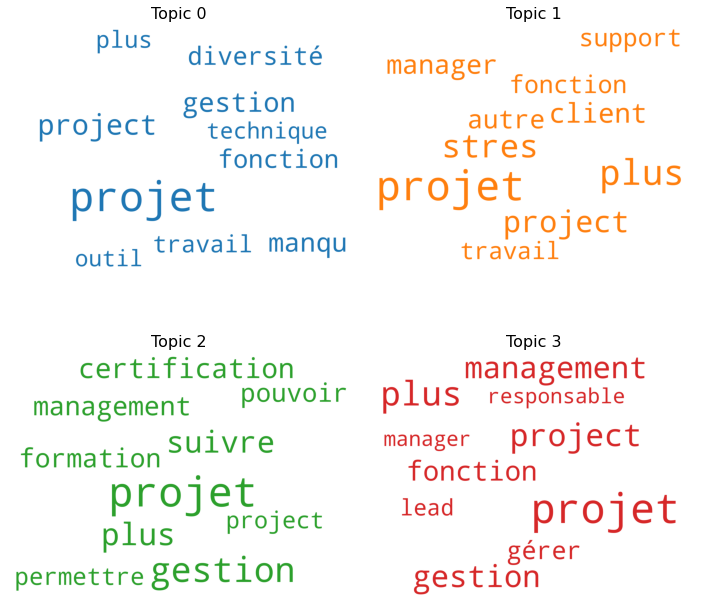

In [24]:
# Creating a wordcloud for each of the relevant topics
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stops,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-25-e37796ad1362>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-25-e37796ad1362>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-25-e37796ad1362>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-25-e37796ad1362>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


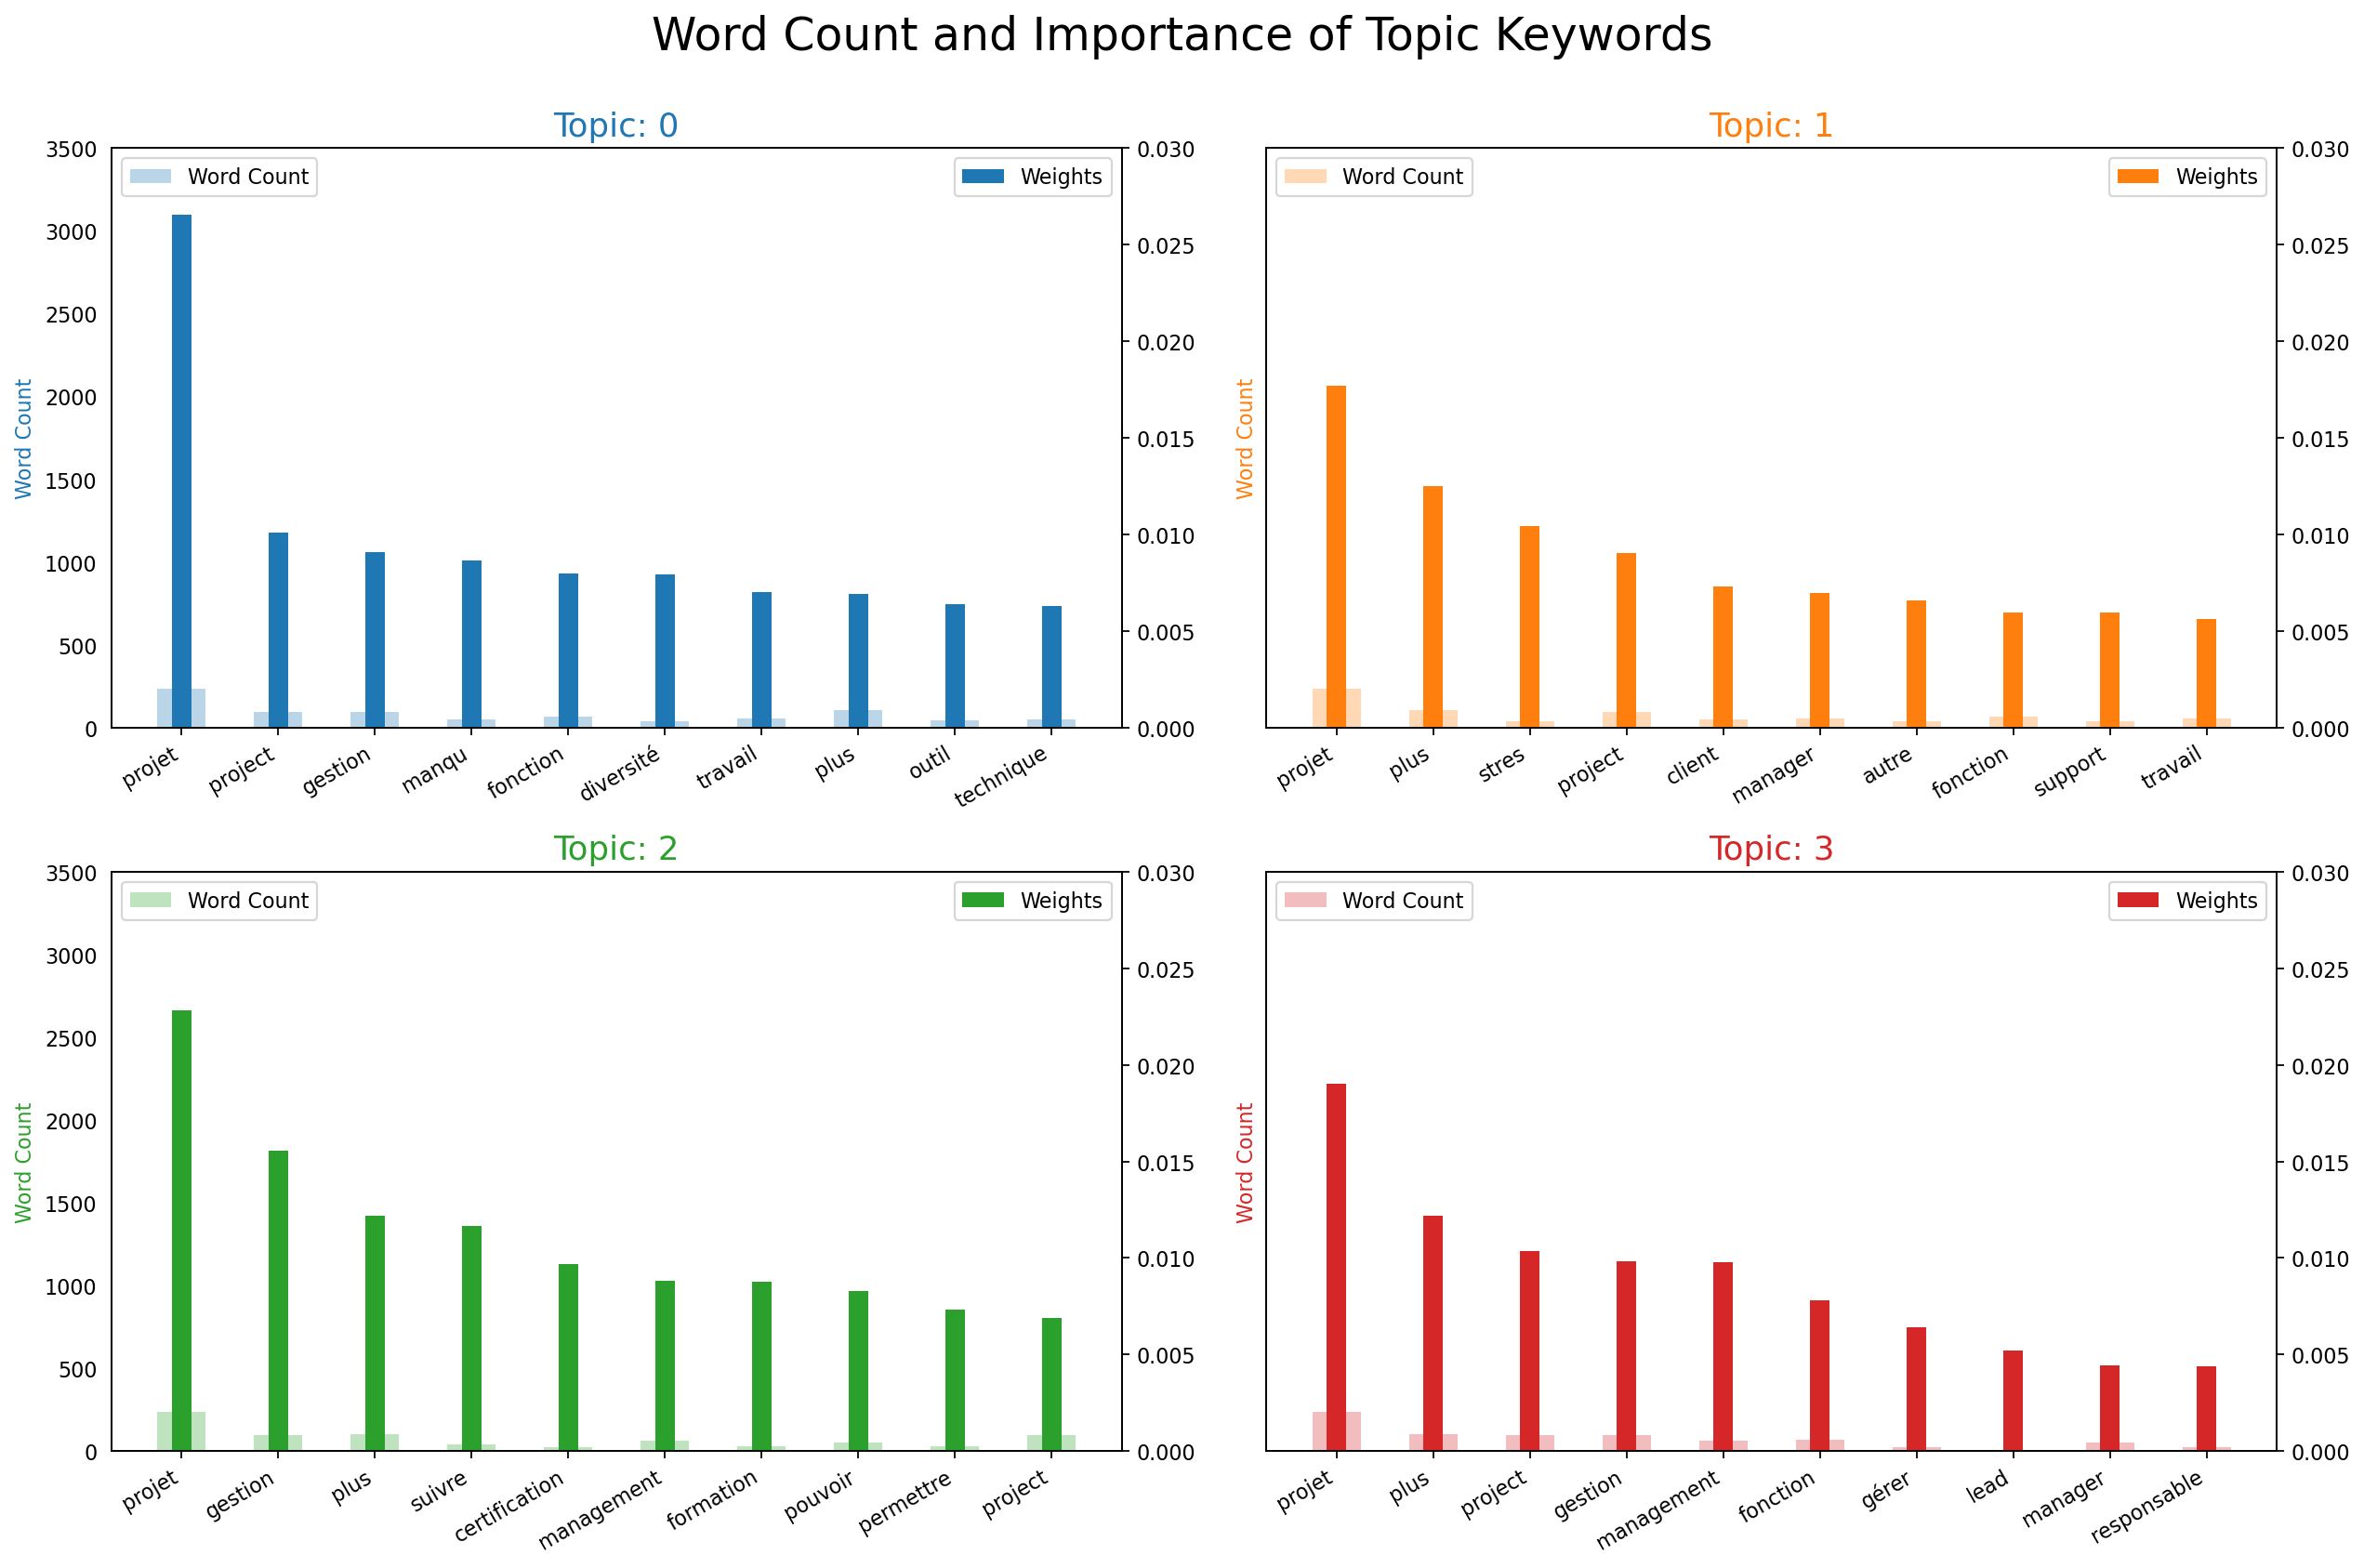

In [25]:
# Plotting word count for each topic 
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [26]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

### KeyBERT

In [27]:
from keybert import KeyBERT

In [28]:
master_corpus

,index,corpus,token
0,"Si vous effectuez d'autres tâches, veuillez l'indiquer ci-dessous",administratives : gestion des documents title block flux d'approbation préparation de work pa...,"[administratives, gestion, documents, title, block, flux, d'approbation, préparation, work, pack..."
1,Quelles sont vos aspirations futures ?,continuer à gérer des équipes de projets j'ai répondu au questionnaire comme si j étais toujours...,"[continuer, gérer, équipes, projets, j'ai, répondu, questionnaire, comme, si, toujours, pm, sect..."
2,"Y a-t-il un facteur supplémentaire qui vous semble utile de mentionner ? Si oui, lequel ?",arrêter cette ambiguïté du tandem PM et TPM il faut un seul patron dans une équipe et c'est le ...,"[arrêter, cette, ambiguïté, tandem, pm, tpm, faut, seul, patron, équipe, c'est, pm, difficulté, ..."
3,"Si oui ou non, expliquez pourquoi ...",ce serait une redite Ancrage des formations suivies en interne Valorisation de notre métier déj...,"[redite, ancrage, formations, suivies, interne, valorisation, métier, déjà, certifié, temps, per..."
4,Commentaire libre pour vous exprimer sur votre niveau de stress :,"Mieux savoir faire les parts de choses et ""remballer"" les clients avec ses attentes peu cohérent...","[mieux, savoir, faire, parts, choses, ``, remballer, '', clients, attentes, peu, cohérentes, afi..."
5,"Selon vous, quels sont les 3 aspects les plus intéressants chez John Cockerill ?",diversité des business excepté la défense. la localisation Variété des projets niveau de resp...,"[diversité, business, excepté, défense, localisation, variété, projets, niveau, responsabilité, ..."
6,"Selon vous, quels sont les 3 aspects les plus pénibles chez John Cockerill ?",entreprise qui donne une image moderne mais qui est ancrée dans son passé gérée par des manager...,"[entreprise, donne, image, moderne, ancrée, passé, gérée, managers, issus, monde, production, ge..."
7,"Selon vous, quelle est la première action à prendre pour valoriser le métier ?",remettre le PM au centre du projet c'est le patron de l'équipe projet. moderniser cet outil pro...,"[remettre, pm, centre, projet, c'est, patron, l'équipe, projet, moderniser, cet, outil, promocor..."
8,"Si vous le souhaitez, n'hésitez pas à ajouter un commentaire. \n\nNous vous remercions d'avoir p...",bonne chance Je pense qu'il est important que JC se positionne sur le rôle d...,"[bonne, chance, pense, qu'il, important, jc, positionne, rôle, pm, cherche, ``, pm, '', sens, pr..."
9,"Si autre, à préciser(combined)",Plus challenger Savoir monter au front lors de situations délicates avec clients/fournisseurs/...,"[plus, challenger, savoir, monter, front, lors, situations, délicates, clients/fournisseurs/autr..."


In [29]:
kw_model = KeyBERT()
master_corpus['keywords'] = master_corpus['corpus'].map(lambda x: kw_model.extract_keywords(x) )

In [30]:
master_corpus['keywords'][0][0]

('départements', 0.3761)

In [31]:
master_corpus['keywords']

0    [(départements, 0.3761), (procédures, 0.3583), (amendements, 0.3581), (développement, 0.3359), (...
1           [(gérer, 0.3963), (projet, 0.2984), (projets, 0.2803), (une, 0.2761), (extérieures, 0.2713)]
2    [(permettre, 0.347), (problématiques, 0.3087), (une, 0.3018), (perdu, 0.2974), (gestionnaire, 0....
3    [(standardization, 0.3356), (certifications, 0.3334), (certification, 0.313), (pmbok, 0.2872), (...
4     [(stressé, 0.4329), (stress, 0.3985), (stressant, 0.3935), (stressful, 0.3214), (urgency, 0.3142)]
5    [(diversité, 0.4496), (globalement, 0.4491), (diversification, 0.4435), (organisationnel, 0.3817...
6    [(administratif, 0.3907), (désinvestissement, 0.3685), (compétente, 0.3684), (management, 0.3676...
7    [(organisationnelle, 0.3934), (connaitre, 0.3932), (permettre, 0.3785), (management, 0.3476), (d...
8    [(pratiques, 0.3771), (responsabilités, 0.3415), (responsabilité, 0.3193), (pmi, 0.318), (projet...
9    [(départements, 0.3764), (contre, 0.3598), (départ

In [32]:
# master_corpus.to_excel("../data/keyBERT_results.xlsx")